In [12]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# define matplotlib style
plt.style.use("classic")
mpl.rc("xtick", labelsize=23)
mpl.rc("ytick", labelsize=23)
mpl.rc("xtick.major", size=15, width=2)
mpl.rc("xtick.minor", size=8, width=2, visible=True)
mpl.rc("ytick.major", size=15, width=2)
mpl.rc("ytick.minor", size=8, width=2, visible=True)
mpl.rc("lines", linewidth=3, markersize=20)
mpl.rc("axes", linewidth=2, labelsize=30, labelpad=2.5)
mpl.rc("legend", fontsize=25, loc="best", frameon=False, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")

In [13]:
import numpy as np

In [14]:
from tidaldisruptionlrd import stellar_distribution, tdr_rate

In [15]:
import importlib

importlib.reload(stellar_distribution)
importlib.reload(tdr_rate)

<module 'tidaldisruptionlrd.tdr_rate' from '/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/tdr_rate.py'>

In [16]:
class IsothermalSphereLossCone(stellar_distribution.BaseLossCone):
    def __init__(
        self,
        r_bin_min_scaler=1e-4,
        r_bin_max_scaler=1e6,
        N_bins=10000,
        reduce_factor=10,
        N_trapz_bins=1000,
    ):
        super().__init__(
            r_bin_min=r_bin_min_scaler,
            r_bin_max=r_bin_max_scaler,
            N_bins=N_bins,
            reduce_factor=reduce_factor,
            N_trapz_bins=N_trapz_bins,
        )

    def _get_stellar_rho_bins(self, r_bins):
        return 1 / (2 * np.pi * r_bins**2)

In [17]:
isothermal_sphere_lc = IsothermalSphereLossCone()

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/stellar_distribution.py:132: RuntimeWarning: invalid value encountered in log
  np.log(_psi_interp_bins), np.log(_d2rho_dpsi2_bins)
Eddington's inversion: 100%|██████████| 9999/9999 [00:12<00:00, 806.09it/s] 
/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/stellar_distribution.py:311: RuntimeWarning: invalid value encountered in log
  _log_log_Jc_sqr_interp = get_interp(np.log(_orbit_epsilon_bins), np.log(_orbit_Jc_sqr_bins))
/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/stellar_distribution.py:341: RuntimeWarning: divide by zero encountered in log
  _log_log_g_epsilon_interp = get_interp(np.log(self.epsilon_bins), np.log(self.g_epsilon_bins))
/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/stellar_distribution.py:344: RuntimeWarning: divid

/Users/vinhtran/Data/Research/Mark/LRD Tidal Disruption/TidalDisruptionLRD/src/tidaldisruptionlrd/stellar_distribution.py:220: RuntimeWarning: divide by zero encountered in log
  _log_log_eddington_interp = get_interp(np.log(epsilon_bins), np.log(g_epsilon_bins))
Reconstructing densities: 100%|██████████| 10000/10000 [00:10<00:00, 951.49it/s]


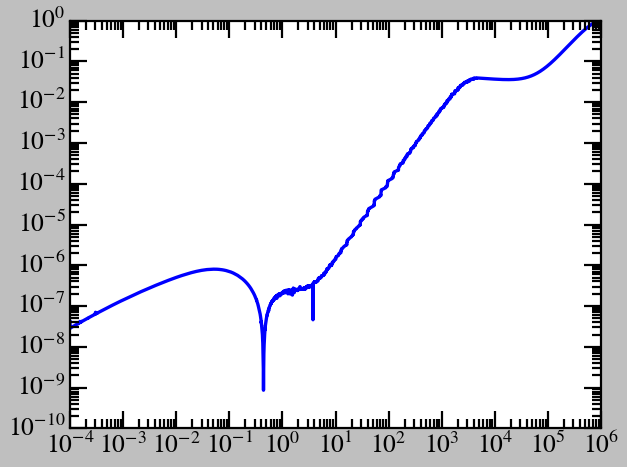

In [18]:
reconstructed_stellar_rho_bins = isothermal_sphere_lc.reconstruct_stellar_rho_bins(
    -isothermal_sphere_lc.phi_bins,
    isothermal_sphere_lc.epsilon_bins,
    isothermal_sphere_lc.g_epsilon_bins,
)

plt.plot(
    isothermal_sphere_lc.r_bins,
    np.abs(1 - reconstructed_stellar_rho_bins / isothermal_sphere_lc.stellar_rho_bins),
)

plt.xscale("log")
plt.yscale("log")

plt.tight_layout()
plt.show()

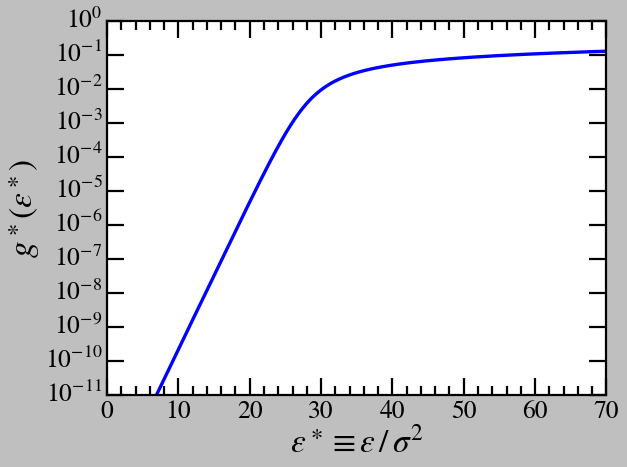

In [19]:
plt.plot(
    isothermal_sphere_lc.epsilon_bins,
    isothermal_sphere_lc.g_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-11, 1e0)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$g^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

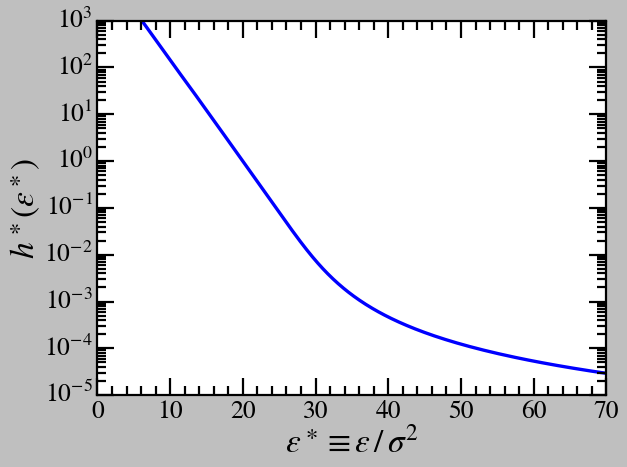

In [20]:
plt.plot(
    isothermal_sphere_lc.reduced_epsilon_bins,
    isothermal_sphere_lc.reduced_h_epsilon_bins,
)

# plt.xscale("log")
plt.yscale("log")

plt.xlim(0, 70)
plt.ylim(1e-5, 1e3)

plt.xlabel(r"$\epsilon^\ast \equiv \epsilon \, / \, \sigma^2$")
plt.ylabel(r"$h^\ast (\epsilon^\ast)$")

plt.tight_layout()
plt.show()

In [ ]:
tdr = tdr_rate.TDRRate(
    eta_ast_bins=isothermal_sphere_lc.reduced_epsilon_bins,
    g_ast_bins=isothermal_sphere_lc.reduced_g_epsilon_bins,
    h_ast_bins=isothermal_sphere_lc.reduced_h_epsilon_bins,
    Jc_sqr_ast_bins=isothermal_sphere_lc.reduced_Jc_sqr_bins,
    M_bh=np.logspace(4, 8, 1000),
    sigma=100,
    m_s=1,
    r_s=1,
)

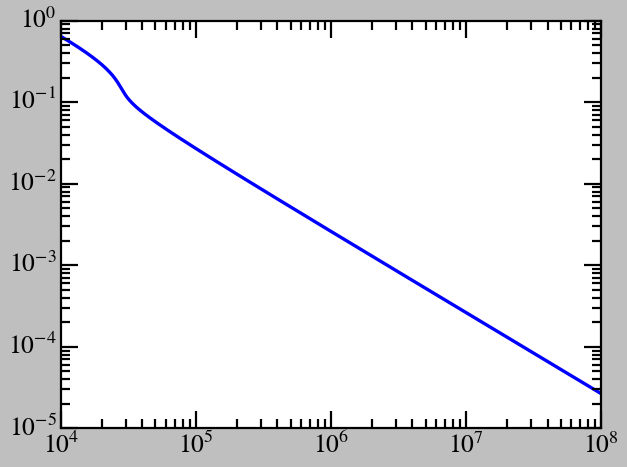

In [22]:
plt.plot(tdr.M_bh, tdr.N_rate)

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e4, 1e8)
plt.ylim(1e-5, 1e0)

plt.tight_layout()
plt.show()